# Fake News Classifier

In this notebook, we'll attempt to classify a news article as either legitimate or fake.

## Preparing our tools

In [101]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from wordcloud import WordCloud

import nltk
import re

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

# Importing models from sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Importing Model Evaluation tools

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

## Data Analysis

The data being used has been imported from https://www.kaggle.com/competitions/fake-news/data.

Here, we'll do some exploratory data analysis (EDA).

In [2]:
df = pd.read_csv("./data/train.csv", index_col = 0) # Importing data

df.shape

(20800, 4)

In [3]:
df.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

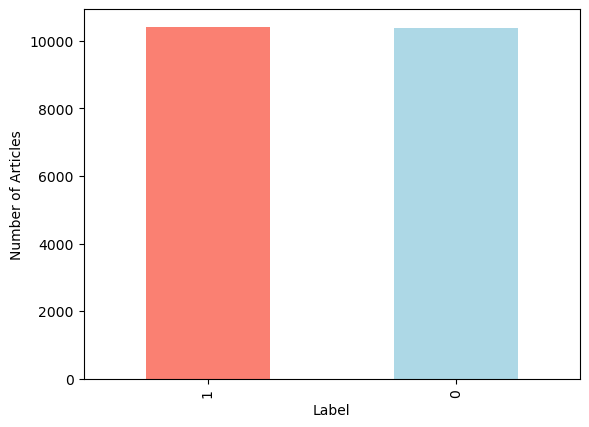

In [5]:
df.label.value_counts().plot(kind = "bar", color = ["salmon", "lightblue"], xlabel = "Label", ylabel = "Number of Articles");

Data Features

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20242 non-null  object
 1   author  18843 non-null  object
 2   text    20761 non-null  object
 3   label   20800 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 812.5+ KB


Checking for any missing values in our data

In [7]:
df.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

Filling missing values with the string 'MISS'

In [8]:
missing = 'MISS'
df = df.fillna(missing)

In [9]:
df.isnull().sum()

title     0
author    0
text      0
label     0
dtype: int64

In [10]:
df["text"]

id
0        House Dem Aide: We Didn’t Even See Comey’s Let...
1        Ever get the feeling your life circles the rou...
2        Why the Truth Might Get You Fired October 29, ...
3        Videos 15 Civilians Killed In Single US Airstr...
4        Print \nAn Iranian woman has been sentenced to...
                               ...                        
20795    Rapper T. I. unloaded on black celebrities who...
20796    When the Green Bay Packers lost to the Washing...
20797    The Macy’s of today grew from the union of sev...
20798    NATO, Russia To Hold Parallel Exercises In Bal...
20799      David Swanson is an author, activist, journa...
Name: text, Length: 20800, dtype: object

Calculating average length of an entry in the "text" column

In [11]:
sum = 0
for string in df["text"][:100]:
    sum += len(string)
sum / 100

5631.14

 Since the text column has very long entries, let's try to solve our problem without the column.

In [12]:
df.drop("text", axis = 1, inplace = True)

Since we're going to be using only the fields 'title' and 'author' to predict the label, and they are both of the type 'string', it makes sense to combine them



In [13]:
df.head()

,title,author,label
id,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,1


In [14]:
df["info"] = df["title"] + ' ' + df["author"]

In [15]:
df.head()

,title,author,label,info
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired,Consortiumnews.com,1,Why the Truth Might Get You Fired Consortiumne...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,1,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,1,Iranian woman jailed for fictional unpublished...


In [16]:
df.drop("author", axis = 1, inplace = True)
df.drop("title", axis = 1, inplace = True)
df.head()

,label,info
id,,
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,1,Why the Truth Might Get You Fired Consortiumne...
3,1,15 Civilians Killed In Single US Airstrike Hav...
4,1,Iranian woman jailed for fictional unpublished...


Seperating data into dependent and independent variables

In [103]:
X = df["info"]
y = df["label"]

In [104]:
X.describe()

count              20800
unique             20412
top       MISS Anonymous
freq                  61
Name: info, dtype: object

In [105]:
y.describe()

count    20800.000000
mean         0.500625
std          0.500012
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

Lemmatizing the words into their root forms:

In [20]:
lemmatizer = WordNetLemmatizer()

In [21]:
def lemmatize(info):
    
    '''
    Lemmatizes the given string
    '''
    
    info = re.sub('[^a-zA-Z]',' ', info).lower().split()
    info = [lemmatizer.lemmatize(word) for word in info if not word in stopwords.words('english')]
    info = ' '.join(info)
    
    return info

In [106]:
X = X.apply(lemmatize)

In [107]:
X.head()

id
0    house dem aide even see comey letter jason cha...
1    flynn hillary clinton big woman campus breitba...
2             truth might get fired consortiumnews com
3    civilian killed single u airstrike identified ...
4    iranian woman jailed fictional unpublished sto...
Name: info, dtype: object

Generating WordCloud

Note: The bigger the word is, the more is its frequency in the data

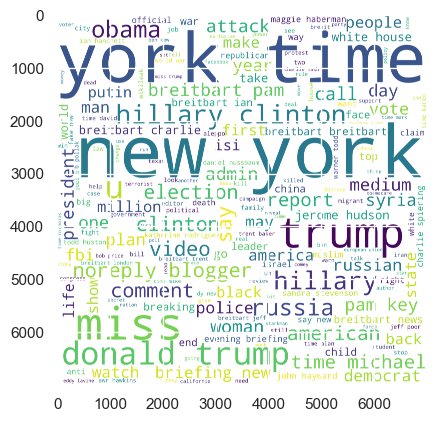

In [115]:
wc = WordCloud(width = 7000, height = 7000, min_font_size = 10, background_color = 'white')
X_wc = wc.generate(X.str.cat(sep = " "))
plt.imshow(X_wc);

In [24]:
X.shape

(20800,)

Now, let's convert out textual data into numeric form using Term Frequency - Inverse Document Frequency (TF-IDF) method

This method uses statistical values to convert a word into some numeric form.

* Term Frequency: The ratio of number of times a word appears in a document to total number of words in that document

* Inverse Document Frequency: Log of ratio of number of documents in the corpus to number of documents in which the word has occurred.

The Term Frequency (TF) value shows how frequent is the word in a document and IDF value shows how infrequent or rare is the word in other documents.

For more information, read here: https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

In [25]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [26]:
print(X[:1])

  (0, 19361)	0.3898334584250517
  (0, 16636)	0.2434231886663421
  (0, 11060)	0.33838114561245775
  (0, 10711)	0.27186640212962043
  (0, 9676)	0.23066376406357905
  (0, 8757)	0.20553409740940168
  (0, 6290)	0.25787634753604916
  (0, 4706)	0.2800374370965301
  (0, 4440)	0.3349354477607908
  (0, 3567)	0.22972642932451354
  (0, 2995)	0.34215548056905637
  (0, 372)	0.27922090210909


In [85]:
X

<20800x21030 sparse matrix of type '<class 'numpy.float64'>'
	with 212715 stored elements in Compressed Sparse Row format>

## Model Selection

Now let's try out different models on our curated data. The following models will be tested upon:

* KNeighborsClassifier
* Logistic Regressor
* Random Forest Classifier

Splitting data into training and test sets:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 37)

In [29]:
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),
          "Random Forest": RandomForestClassifier()}

In [30]:
def fit_and_score(models, X_train, X_test, y_train, y_test):
    
    '''
    Fits and evaluates the given Machine Learning models
    '''
    
    np.random.seed(37)
    
    model_scores = {}
    
    for name, model in models.items():
        
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
        
    return model_scores

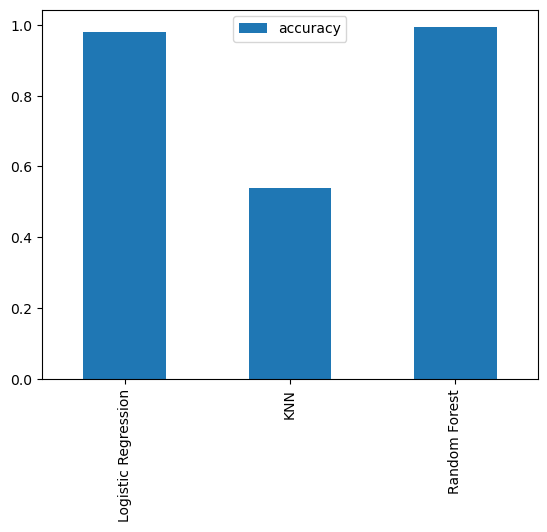

In [31]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_compare = pd.DataFrame(model_scores, index = ["accuracy"])

model_compare.T.plot.bar();

KNN model seems to be doing not so good. So let's discard that model and try to improve upon our remaining models.

## Hyperparameter tuning

There is a kind of parameter, known as Hyperparameters, that cannot be directly learned from the regular training process. They are usually fixed before the actual training process begins. These parameters express important properties of the model such as its complexity or how fast it should learn.

Here, we'll be using Random Search CV and Grid Search CV to tune the hyperparameters.

1) Logistic Regressor

In [32]:
# Parameter space to search over for Logistic Regressor

log_reg_grid = {"C" : np.logspace(-4,4,20),
               "solver" : ["liblinear"]}

In [33]:
log_reg_gs = GridSearchCV(LogisticRegression(), param_grid = log_reg_grid, cv = 5, verbose = True)
log_reg_gs.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [34]:
log_reg_gs.best_params_

{'C': 10000.0, 'solver': 'liblinear'}

In [35]:
log_reg_gs.score(X_test, y_test)

0.9939903846153846

Here, we can see that Logistic Regressor works extremely well on our problem.

2) Random Forest Regressor

In [36]:
# Parameter space to search over for Random Forest Classifier

rand_forest_grid = {"n_estimators" : np.arange(10,1000,50),
                   "max_depth" : [None, 3, 5, 10, 50],
                   "min_samples_split" : np.arange(2,20,2),
                   "min_samples_leaf" : np.arange(1,20,2),
                   "n_jobs" : [-1]}

In [37]:
rand_forest_rs = RandomizedSearchCV(RandomForestClassifier(), param_distributions = rand_forest_grid, cv = 5, n_iter = 20, verbose = True)
rand_forest_rs.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10, 50],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960]),
                                        'n_jobs': [-1]},
                   verbose=True)

In [38]:
rand_forest_rs.best_params_

{'n_jobs': -1,
 'n_estimators': 260,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_depth': None}

In [39]:
rand_forest_rs.score(X_test, y_test)

0.9925480769230769

Saving our models using Pickle

In [40]:
pickle.dump(log_reg_gs, open("./models/log_reg_gs.pkl", 'wb'))

In [41]:
pickle.dump(rand_forest_rs, open("./models/rand_forest_rs.pkl", 'wb'))

## Model Evaluation

We'll be using the following tools for evaluating our models:

* Confusion Matrix
* Classification Report
* ROC Curve

In [59]:
def plot_conf_mat(cm):
    '''
    Plots a confusion matrix using heatmap
    '''
    fig, ax = plt.subplots(figsize = (3,3))
    ax = sns.heatmap(cm, annot = True, cbar = False)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

### Logistic Regressor

Accuracy:  0.9940


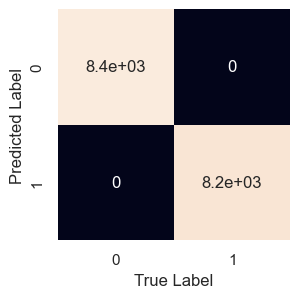

In [62]:
y_preds = log_reg_gs.predict(X_train)
print("Accuracy: % 0.4f" % log_reg_gs.score(X_test, y_test))
plot_conf_mat(confusion_matrix(y_train,y_preds))

In [63]:
print(classification_report(y_train,y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8396
           1       1.00      1.00      1.00      8244

    accuracy                           1.00     16640
   macro avg       1.00      1.00      1.00     16640
weighted avg       1.00      1.00      1.00     16640



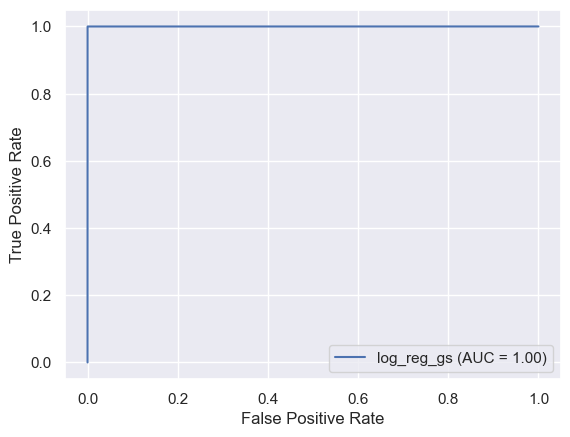

In [74]:
fpr, tpr, thresholds = roc_curve(y_train, y_preds)
roc_auc = auc(fpr, tpr)
display.plot();

### Random Forest Regressor

Accuracy:  0.9925


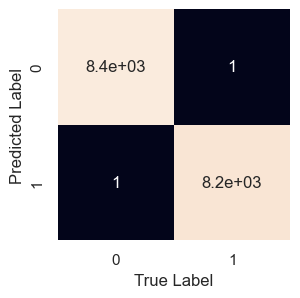

In [75]:
y_preds = rand_forest_rs.predict(X_train)
print("Accuracy: % 0.4f" % rand_forest_rs.score(X_test, y_test))
plot_conf_mat(confusion_matrix(y_train,y_preds))

In [76]:
print(classification_report(y_train,y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8396
           1       1.00      1.00      1.00      8244

    accuracy                           1.00     16640
   macro avg       1.00      1.00      1.00     16640
weighted avg       1.00      1.00      1.00     16640



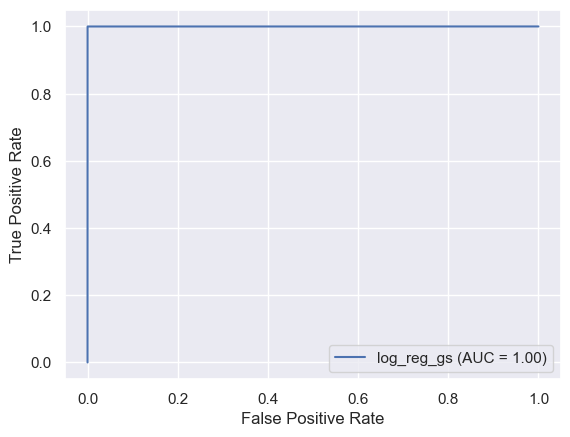

In [77]:
fpr, tpr, thresholds = roc_curve(y_train, y_preds)
roc_auc = auc(fpr, tpr)
display.plot();